# Exercise 5 - Beamforming

In [80]:
## IMPORTS
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.signal.windows import triang, hamming
from copy import copy

from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.ksensor import kSensor
from kwave.ksource import kSource
from kwave.kspaceFirstOrder2D import kspaceFirstOrder2D
from kwave.utils.signals import tone_burst
from kwave.kWaveSimulation import SimulationOptions
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.utils.colormap import get_color_map

In [81]:
## SET UP SIMULATION

c0 = 1540                       # [m/s] Speed of sound
rho0 = 1000                     # [kg/m^3] Density of water
source_f0 = 1e6                 # [Hz] Source frequency
source_amp = 1e6                # [Pa] Source amplitude
source_cycles = 75               # Number of cycles in the pulse
source_aperture = 2e-2          # Aperture size

grid_size_x = 80e-3             # [m] Grid size in x (NB: Depth in k-Wave)
grid_size_y = 40e-3             # [m] Grid size in z (NB: Width in k-Wave)
ppw = 5                       # Points per wavelength
cfl = 0.05                       # Related to the time resolution, lower is more accurate (no need to change)

# Setup Grid
dx = c0 / (ppw * source_f0)     # Grid resolution
Nx = round(grid_size_x / dx)    # Number of grid points in x, NB: This is depth
Ny = round(grid_size_y / dx)    # Number of grid points in y, NB: This is width (lateral)

# Make sure Ny is odd to make centering easier
if Ny % 2 == 0:
    Ny += 1

kgrid = kWaveGrid([Nx, Ny], [dx, dx])
kgrid.makeTime(c0, cfl)         # Make time array based on the Courant-Friedrichs-Lewy (CFL) condition

# Setup source
source_pos = [-grid_size_y, 0]
N_source_x = np.max(np.round((source_pos[0] - kgrid.x_vec[0]) / dx).astype(int)[0], 0)
z_ax = kgrid.x_vec - kgrid.x_vec[0]
extent = np.array([z_ax[0], z_ax[-1], kgrid.y_vec[0], kgrid.y_vec[-1]])*1e3

# Define kWave source object
source = kSource()
source.p_mask = np.zeros_like(kgrid.x)

N_aperture = round(source_aperture/dx)
if N_aperture % 2 == 0:
    N_aperture += 1

N_source_y = np.round((np.arange(kgrid.Ny/2 - N_aperture/2, kgrid.Ny/2 + N_aperture/2, 1))).astype(int)

source.p_mask[N_source_x, N_source_y] = 1
print(source.p_mask.shape)

# Setup sensor
sensor = kSensor(record=['p', 'p_max'])                     # Sensor object, record pressure and maximum pressure
sensor.mask = np.ones_like(kgrid.x)                         # Sensor mask, all grid points

# Setup medium
medium = kWaveMedium(sound_speed=c0, density=rho0)          # Define medium object, simple homogeneous medium
medium.sound_speed = np.ones_like(kgrid.x) * c0
medium.density = np.ones_like(kgrid.x) * rho0

(260, 131)


65
dt: 1.00e-08. Fs: 1.00e+08


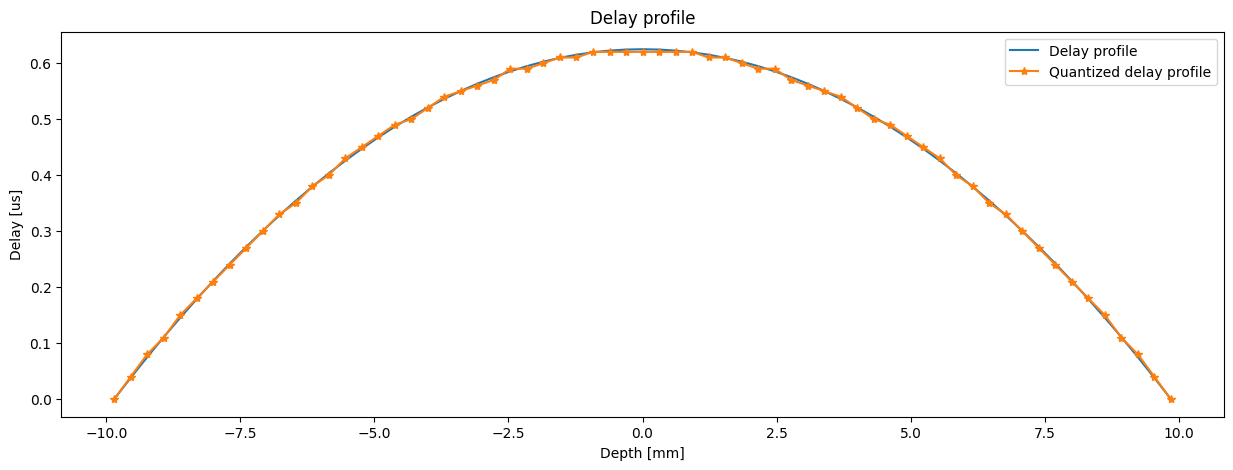

In [82]:
def delay_profile(source, fp, angle):
    x = source[0]
    y = source[1]

    dx = x - fp[0]
    dy = y - fp[1]
    d_source_fp = np.sqrt(dx**2 + dy**2)

    center_x = x[len(x)//2] - fp[0]
    center_y = y[len(y)//2] - fp[1]
    d_center = np.sqrt(center_x**2 + center_y**2)

    delay_profile = (d_center - d_source_fp) / c0
    delay_profile = delay_profile - np.min(delay_profile)

    # delay_profile += np.tan(angle) * y / c0
    delay_profile = delay_profile + np.tan(angle) * y / c0

    return delay_profile

focal_point = np.array([0.05, 0])
angle = 0
# angle = 5
source_x_y = [np.zeros_like(kgrid.y_vec[N_source_y]), kgrid.y_vec[N_source_y]]

dp = delay_profile(source_x_y, focal_point, angle*np.pi/180)

quantized = np.round(dp / kgrid.dt).astype(int)
quantized -= np.min(quantized)

print(len(quantized))
# print(dp)

print(f"dt: {kgrid.dt:.2e}. Fs: {1/kgrid.dt:.2e}")

plt.figure(figsize=(15, 5))
plt.plot(source_x_y[1]*1e3, dp*1e6)
plt.plot(source_x_y[1]*1e3, quantized*kgrid.dt*1e6, "*-")
plt.title("Delay profile")
plt.xlabel("Depth [mm]")
plt.ylabel("Delay [us]")
plt.legend(["Delay profile", "Quantized delay profile"])

In [83]:
# source_amp = source_amp * np.expand_dims(triang(len(quantized)), 1) # Apodization: triangular window
source_amp = source_amp * np.expand_dims(hamming(len(quantized)), 1) # Apodization: hamming window
source.p = source_amp * tone_burst(1 / kgrid.dt, source_f0, source_cycles, signal_offset=quantized)
print(source.p.shape)

# Setup simulation options
simulation_options = SimulationOptions(
    pml_auto=True,
    pml_inside=False,
    save_to_disk=True,
    data_cast='single',
)
execution_options = SimulationExecutionOptions(is_gpu_simulation=False)

# Run 2D simulation (to save some time)
sensor_data = kspaceFirstOrder2D(kgrid=kgrid, medium=medium, source=source, sensor=sensor,
                                  simulation_options=simulation_options, execution_options=execution_options)

# Extract pressure field from
p_field = np.reshape(sensor_data["p"], (kgrid.Nt, Nx, Ny), order="F")   # Stored in Fortran ordering for some reason

(65, 7562)
┌───────────────────────────────────────────────────────────────┐
│                   kspaceFirstOrder-OMP v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Number of CPU threads:                                     16 │
│ Processor name: AMD Ryzen 7 PRO 7840U w/ Radeon 780M Graphics │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                                  288 x 175 │
│ Medium type:                                               2D │
│ Simulation time steps:                                   5823 │
├───────────────────────────────────────────────────────────────┤
│                        Initialization                         │
├───────────────────────────────────────────────────────────────┤

## Observations (5.1)

a) I ended up using `cfl = 0.05` and a sample time of `1e-8` (`F_s ~ 10MHz`).

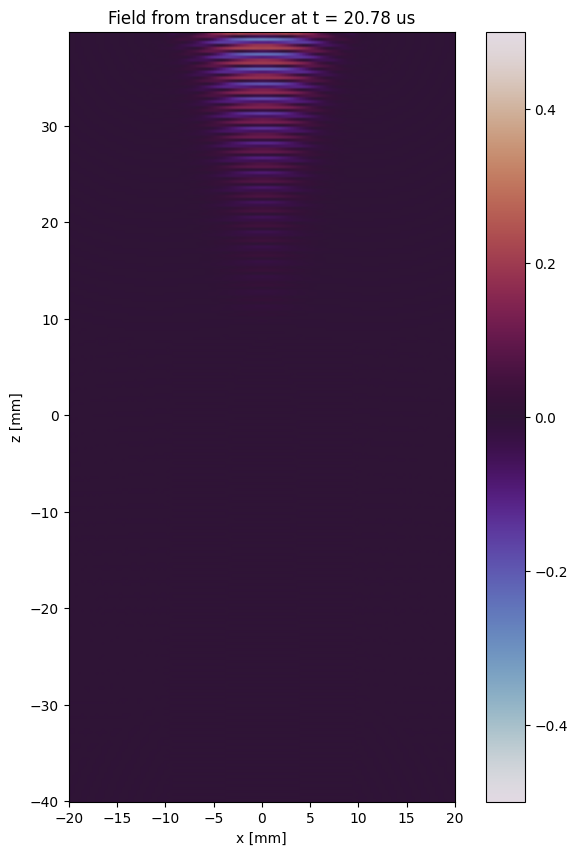

In [84]:
# P-field visualization

vt = grid_size_x / 2 / c0 * 0.8 # Time to vizualize [s]
NFrames = np.round(np.where(kgrid.t_array[0] > vt)[0][0]).astype(int) # Number of frames to vizualize

pPlot = p_field / np.max(np.abs(p_field)) # Normalize frames

extent = np.array([kgrid.y_vec[0], kgrid.y_vec[-1], kgrid.x_vec[0], kgrid.x_vec[-1]])*1e3

fig, ax = plt.subplots(figsize=(8, 10))
img = plt.imshow(pPlot[NFrames], cmap="twilight", vmin=-0.5, vmax=0.5, extent=extent)
plt.colorbar()
plt.xlabel("x [mm]")
plt.ylabel("z [mm]")
plt.title(f"Field from transducer at t = {vt*1e6:.2f} us")
plt.show()


In [47]:

# Create animation showing propagation over time
def update(frame):
    img.set_data(pPlot[frame])
    ax.set_title(f"Frame: {frame}/{kgrid.Nt}")
    return [img]

ANIM_START = 0
ANIM_END = kgrid.Nt
ANIM_STEP = 10
ANIM_FILENAME = "task1_focused_beam.mp4"

animation = FuncAnimation(fig, update, frames=np.arange(ANIM_START, ANIM_END, ANIM_STEP), interval=100, blit=True)

from os import makedirs
makedirs(f"../output/5/", exist_ok=True)
animation.save(f"../output/5/{ANIM_FILENAME}", writer='ffmpeg', fps=30)

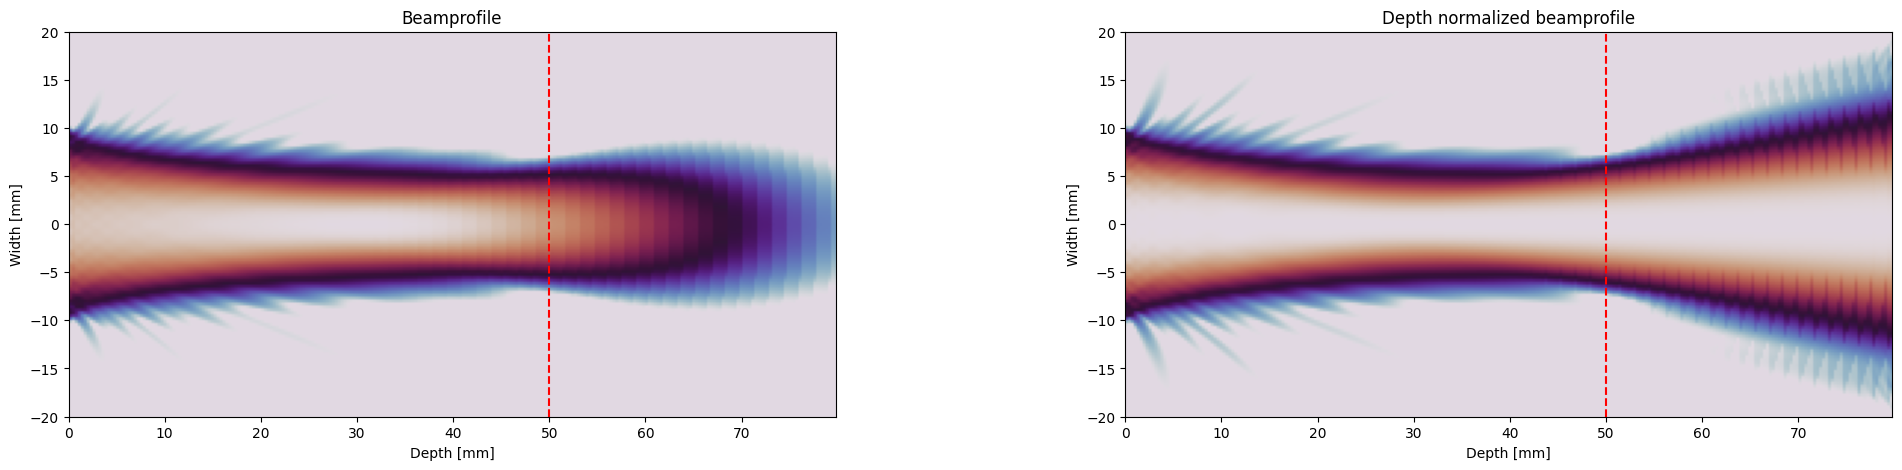

In [85]:
# Visualizing the beamprofile

# Maximum pressure field
pMax = np.reshape(sensor_data["p_max"], (Nx, Ny), order="F")
pMaxDb = 20 * np.log10(pMax)
pMaxDb -= np.max(pMaxDb)

# Depth normalization
dMax = np.max(pMax, axis=1)
pMaxNorm = pMax / dMax[:, None]
pMaxNormDb = 20 * np.log10(pMaxNorm)

# Transition zone
transitionZ = source_aperture**2 / (np.pi * c0 / source_f0)
apertureStart = kgrid.x_vec[N_source_x]
zEnd = apertureStart + transitionZ
zFocus = focal_point[0]

# Plot setup
zAxis = kgrid.x_vec - kgrid.x_vec[0]
xAxis = kgrid.y_vec
extent = np.array([zAxis[0], zAxis[-1], xAxis[0], xAxis[-1]])*1e3

fig, axes = plt.subplots(1, 2, figsize=(25, 5))
axes[0].imshow(pMaxDb[::,:].T, cmap="twilight", extent=extent, vmin=-40, vmax=0)
axes[1].imshow(pMaxNormDb[::,:].T, cmap="twilight", extent=extent, vmin=-40, vmax=0)
axes[0].set_title("Beamprofile")
axes[1].set_title("Depth normalized beamprofile")
[ax.set_xlabel("Depth [mm]") for ax in axes]
[ax.set_ylabel("Width [mm]") for ax in axes]
# fig.colorbar()
[ax.plot([zFocus*1e3, zFocus*1e3], [-20, 20], "r--") for ax in axes]
plt.show()

## Observations (5.1)

b) The focal point is close to the region of the beam with minimum width. This makes sense since we have a focused transducer and expect to have the minimum width be approximately at the focal point.


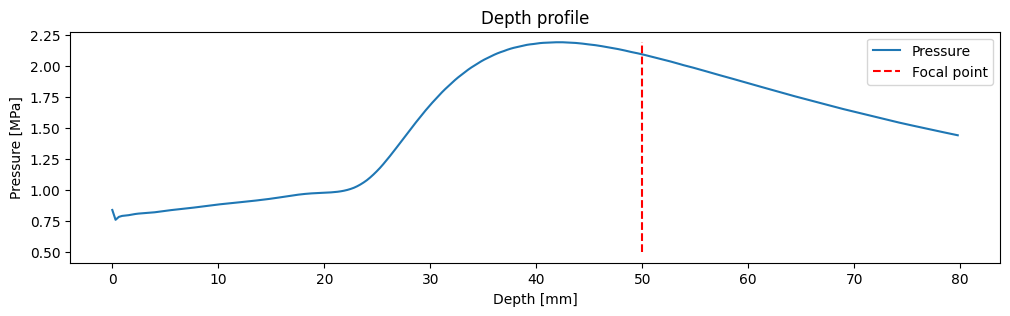

In [49]:
# Depth profile visualization

plt.figure(figsize=(12, 3))
plt.plot(zAxis*1e3, pMax[N_source_x::, Ny//2]*1e-6)
plt.plot([zFocus*1e3, zFocus*1e3], [0.5, np.max(pMax)*1e-6], "r--")
plt.title("Depth profile")
plt.xlabel("Depth [mm]")
plt.ylabel("Pressure [MPa]")
plt.legend(["Pressure", "Focal point"])
plt.show()

## Observations (5.1)

c)  
- In the unfocused beam (from Exercise 4) we saw a maximum pressure around 1.3, while here it's ~2.2 - Quite a bit more. This is to be expected since focusing the beam essentially means squeezing the energy of the pulse into a smaller area (same energy + smaller area ==> greater pressure).
- The point of maximum pressure is *not* exactly at the focal point, rather, it's right before it.

d) See attached image and animation for steered version (or change `angle` and re-run).

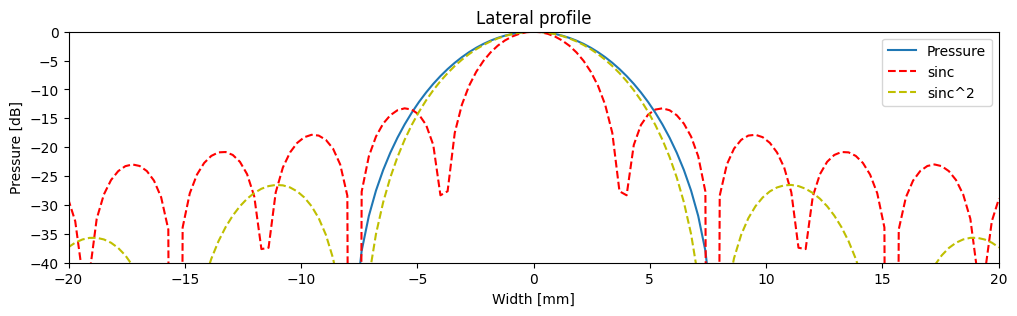

In [86]:
# Lateral profile visualization

# Theoretical profile (more or less copied from Exercise 4)
depthIndices = np.where(zAxis >= focal_point[0])[0][0]
relativeDepth = np.sinc(source_aperture * xAxis / (c0 / source_f0 * (focal_point[0])))
relativeDepthSinc2 = np.sinc(0.5 * source_aperture * xAxis / (c0 / source_f0 * (focal_point[0])))**2

# Plotting
plt.figure(figsize=(12, 3))
plt.plot(xAxis*1e3, pMaxNormDb[depthIndices,:])
plt.plot(xAxis*1e3, 10*np.log10(relativeDepth**2), "r--")
plt.plot(xAxis*1e3, 10*np.log10(relativeDepthSinc2**2), "y--")
plt.title("Lateral profile")
plt.xlabel("Width [mm]")
plt.ylabel("Pressure [dB]")
plt.legend(["Pressure", "sinc", "sinc^2"])
plt.ylim([-40, 0])
plt.xlim([-20, 20])
plt.show()

## Observations (5.2)

a) For a long pulse (75 cycels in this case), the lateral profile resembles a sinc-function (see attached image). 

b) Applying a triangular window to the long pulse, we end up with a lateral profile close to the sinc^2-function. 

c) With the Hamming window applied we no longer see any sidelobes (plot is cut off at -40dB currently. They might still exist at lower amplitudes), but the main lobe is significantly wider.
